pillcam dataset split into neg/pos and trained using resnet.py witouth augmentation or ds normalization.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MODEL = 'resnet50'
DS_INFO = 'binary'
NUM_EPOCHS = 5
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

In [3]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')
class_to_leave_out = 'Anatomic landmarks'

DATASET_SIZE = len(list(data_dir.glob('[!'+class_to_leave_out+']*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
# Remove 'anatomic landmarks'
original_class_names = np.delete(class_names, 0)
class_names = np.array(['Negative', 'Positive'])

neg_class_name = 'Normal'
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

NUM_CLASSES = 2

print ("Positive class names: ", pos_class_names)
print ("Negative class names: ", neg_class_name)

Positive class names:  ['Unknown' 'Protruding lesions' 'Flat lesions' 'Lumen' 'Mucosa'
 'Excavated lesions']
Negative class names:  Normal


In [4]:
# Create a dataset of the file paths | data_dir/*/* but subract class
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!')+str(class_to_leave_out+']*/*'))

In [5]:
# Extract some info about each class

negative_samples = 0
positive_samples = 0
for class_name in original_class_names:
    # Number of samples in 'class_name' folder
    class_samples = len(list(data_dir.glob(class_name+'/*.png')))
    
    if (class_name == neg_class_name):
        negative_samples += class_samples
    else:
        positive_samples += class_samples

print ('Negative samples: {0:5} | {1:5.2f}%'.format(negative_samples, negative_samples/DATASET_SIZE*100))
print ('Positive samples: {0:5} | {1:5.2f}%'.format(positive_samples, positive_samples/DATASET_SIZE*100))
print ('\nTotal number of images:', DATASET_SIZE)

Negative samples: 33129 | 87.77%
Positive samples:  4617 | 12.23%

Total number of images: 37746


Set up pipeline for loading images from given list of paths

In [6]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.uint8),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.uint8),[-1])

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

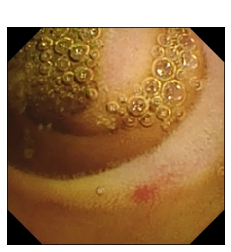

In [7]:
def show_image(img):
    for image, label in img:
        plt.figure()
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

### Splitting into training, test and validation data

In [8]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds#.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [9]:
# Print info about the dataset split
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        37746
Train dataset sample size:       26422
Test dataset sample size:         5661
Validation dataset sample size:   5663


In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/train_{}.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/test_{}.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/val_{}.tfcache".format(IMG_WIDTH))

## Training
https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/

In [11]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import layers

In [12]:
res_net = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE)

In [13]:
res_net.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(1, activation='sigmoid')

tl_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [23]:
tl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
tl_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/transfer_learning_model', update_freq='batch')]

In [15]:
history = tl_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 825 steps, validate for 176 steps
Epoch 1/5
825/825 [==============================] - 543s 658ms/step - loss: 0.2204 - accuracy: 0.9210 - val_loss: 0.7332 - val_accuracy: 0.8734
Epoch 2/5
825/825 [==============================] - 76s 92ms/step - loss: 0.1507 - accuracy: 0.9482 - val_loss: 0.9910 - val_accuracy: 0.8732
Epoch 3/5
825/825 [==============================] - 72s 88ms/step - loss: 0.1269 - accuracy: 0.9566 - val_loss: 1.1383 - val_accuracy: 0.8736
Epoch 4/5
825/825 [==============================] - 73s 88ms/step - loss: 0.1171 - accuracy: 0.9601 - val_loss: 1.2980 - val_accuracy: 0.8741
Epoch 5/5
825/825 [==============================] - 74s 90ms/step - loss: 0.1083 - accuracy: 0.9634 - val_loss: 1.4125 - val_accuracy: 0.8732


`Keras`
Save/load the model

In [15]:
# tl_model.save('models/{}.h5'.format(model_name))
tl_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

`Tensorboard`

In [ ]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [ ]:
# Start tensorboard
%tensorboard --logdir logs

In [ ]:
# !kill 20058

In [18]:
result = tl_model.evaluate(
            val_ds,
            steps = val_size//BATCH_SIZE)

print (result)

176/176 [==============================] - 408s 2s/step - loss: 1.3759 - accuracy: 0.8764
[1.3758898914250814, 0.87642044]


## Predict new samples

In [22]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

True label: Negative
Probabibity of Positive: 0.00163%


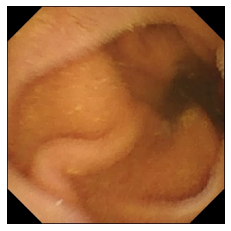

In [63]:
# Get a random image and label
idx = np.random.randint(0, BATCH_SIZE)
image = images[idx]
label = labels[idx]

# Predict one image
result = tl_model.predict(np.expand_dims(image, axis=0))[0][0]

print ("True label:", class_names[label[0]])
print ('Probabibity of Positive: {:.5f}%'.format((result)*100))

plt.figure()
plt.imshow(image)
plt.axis('off');

In [100]:
# Predict one batch
results = tl_model.predict(images)

print ('{:3}  {:7}  {:3}%'.format('idx', 'true_label', 'pred_prob'))
print ('---  ---------   ----------')
idx = 0
for result in results:
    true_label = class_names[labels[idx]][0]
    pred_prob = result[0]
    print ('{:3}  {:10}  {:05f}%'.format(idx, true_label, pred_prob))
    idx += 1

idx  true_label  pred_prob%
---  ---------   ----------
  0  Negative    0.000016%
  1  Negative    0.000017%
  2  Negative    0.000016%
  3  Negative    0.000016%
  4  Positive    0.000010%
  5  Negative    0.000017%
  6  Negative    0.000017%
  7  Negative    0.000016%
  8  Negative    0.000017%
  9  Negative    0.000016%
 10  Negative    0.000011%
 11  Negative    0.000017%
 12  Negative    0.000016%
 13  Positive    0.000016%
 14  Positive    0.000014%
 15  Negative    0.000016%
 16  Negative    0.000013%
 17  Negative    0.000015%
 18  Negative    0.000017%
 19  Negative    0.000016%
 20  Negative    0.000016%
 21  Negative    0.000017%
 22  Negative    0.000016%
 23  Negative    0.000014%
 24  Negative    0.000014%
 25  Negative    0.000015%
 26  Negative    0.000016%
 27  Negative    0.000009%
 28  Negative    0.000017%
 29  Negative    0.000006%
 30  Negative    0.000017%
 31  Negative    0.000007%
